# Date Cleaning and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('poster')
pd.options.display.max_columns = 30

In [2]:
all_teams = pd.read_csv('../data/mlb-game-data-1990-2016.csv')
all_teams.drop_duplicates(inplace=True)

In [3]:
all_teams.head()

,date,box,team,at,opponent,w_or_l,runs,runs_allowed,innings,record,div_rank,gb,winning_pitcher,losing_pitcher,save,time,d_or_n,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day
0,1997-04-02,boxscore,ANA,NaN,BOS,L,5,6,NaN,0-0,0,0,Mahomes,Percival,Slocumb,3:47,N,"30,874",0,0,0.0,NaN,5.8,NaN,1
1,1997-04-03,boxscore,ANA,NaN,BOS,W,2,0,NaN,0-1,3,1.0,Dickson,Wakefield,NaN,2:07,N,"17,323",-,0,5.0,NaN,5.8,NaN,0
2,1997-04-04,boxscore,ANA,NaN,CLE,W-wo,8,6,11.0,1-1,2,0.5,Holtz,Shuey,NaN,4:12,N,"17,758",+,0,3.5,NaN,5.8,NaN,0
3,1997-04-05,boxscore,ANA,NaN,CLE,L,5,7,NaN,2-1,1,Tied,Ogea,Hasegawa,Shuey,3:09,N,"23,913",++,0,5.0,NaN,5.8,NaN,0
4,1997-04-06,boxscore,ANA,NaN,CLE,L,8,10,NaN,2-2,1,Tied,Kline,Percival,Jackson,3:24,N,"29,363",-,0,5.0,NaN,5.8,NaN,0


In [4]:
print all_teams[(all_teams.attendance.isnull()) & (all_teams.double_header == 1)].shape
print all_teams[(all_teams.attendance.isnull()) & (all_teams.double_header == 0)].shape
# not safe to assume that the attendance numbers were the same for each of the games in the double header
# so we must drop these rows

print
print all_teams[(all_teams.attendance.notnull()) & (all_teams.double_header == 1)].shape
# still have enough records to keep the double header feature

(473, 25)
(4, 25)

(1019, 25)


In [5]:
# drop rows without attendance recorded and drop duplicated rows
all_teams = all_teams[all_teams.attendance.notnull()]

# convert datatypes where needed
all_teams.attendance = all_teams.attendance.str.replace(',', '').astype(int)

for col in ['runs', 'runs_allowed', 'div_rank']:
    all_teams[col] = all_teams[col].astype(int)

# create wins, losses, and win pct column
wins = []
losses = []
for wl in all_teams.record:
    w, l = wl.split('-')
    wins.append(int(w))
    losses.append(int(l))

all_teams['wins'] = wins
all_teams['losses'] = losses
all_teams['total_games'] = all_teams.wins + all_teams.losses
all_teams['win_pct'] = all_teams.wins / all_teams.total_games

# convert gb column to floats
all_teams.gb = [0. if x == ' Tied' or x == '0'
         else float(x.replace('up', '')) if 'up' in x
         else -float(x)
         for x in all_teams.gb]

# convert streak column to int
all_teams.streak.fillna('0', inplace=True)
all_teams.streak = [len(x) if '+' in x else -len(x) if '-' in x else 0 for x in all_teams.streak]

# convert d_or_n to dummy variable
all_teams['night_game'] = [1 if x == 'N' else 0 for x in all_teams.d_or_n]

# convert date to datetime
all_teams.date = pd.to_datetime(all_teams.date)
all_teams['year'] = all_teams.date.dt.year
all_teams['month'] = all_teams.date.dt.month
all_teams['day'] = all_teams.date.dt.day
all_teams['weekday'] = all_teams.date.dt.weekday
all_teams['weekday_name'] = all_teams.date.dt.weekday_name

# convert time to timedelta
all_teams.time = pd.to_timedelta([x + ':00' for x in all_teams.time])

# replace null values for win_pct, replacing with zero since first game of season
all_teams.win_pct.fillna(0, inplace=True)

# fill null values for runs_ma and ten_game
all_teams.runs_ma = [all_teams.iloc[i].runs_pg if np.isnan(j) else j for i, j in enumerate(all_teams.runs_ma)]
all_teams.ten_game = [all_teams.iloc[i].win_pct if np.isnan(j) else j for i, j in enumerate(all_teams.ten_game)]

# drop useless columns
all_teams.drop(['box', 'at', 'w_or_l', 'runs', 'runs_allowed', 'innings', 'record', 'winning_pitcher',
                'losing_pitcher', 'save', 'd_or_n', 'wins', 'losses'], axis=1, inplace=True)

In [6]:
print all_teams.shape
print 
print all_teams.dtypes
print
print all_teams.isnull().sum()
print
all_teams.head(15)

(62415, 22)

date                datetime64[ns]
team                        object
opponent                    object
div_rank                     int64
gb                         float64
time               timedelta64[ns]
attendance                   int64
streak                       int64
double_header                int64
runs_pg                    float64
runs_ma                    float64
runs_allowed_ma            float64
ten_game                   float64
opening_day                  int64
total_games                  int64
win_pct                    float64
night_game                   int64
year                         int64
month                        int64
day                          int64
weekday                      int64
weekday_name                object
dtype: object

date               0
team               0
opponent           0
div_rank           0
gb                 0
time               0
attendance         0
streak             0
double_header      0
runs_pg      

,date,team,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name
0,1997-04-02,ANA,BOS,0,0.0,03:47:00,30874,0,0,0.000000,0.0,5.8,0.000000,1,0,0.000000,1,1997,4,2,2,Wednesday
1,1997-04-03,ANA,BOS,3,-1.0,02:07:00,17323,-1,0,5.000000,5.0,5.8,0.000000,0,1,0.000000,1,1997,4,3,3,Thursday
2,1997-04-04,ANA,CLE,2,-0.5,04:12:00,17758,1,0,3.500000,3.5,5.8,0.500000,0,2,0.500000,1,1997,4,4,4,Friday
3,1997-04-05,ANA,CLE,1,0.0,03:09:00,23913,2,0,5.000000,5.0,5.8,0.666667,0,3,0.666667,1,1997,4,5,5,Saturday
4,1997-04-06,ANA,CLE,1,0.0,03:24:00,29363,-1,0,5.000000,5.0,5.8,0.500000,0,4,0.500000,1,1997,4,6,6,Sunday
5,1997-04-07,ANA,NYY,3,-1.0,03:24:00,16514,-2,0,5.600000,5.6,5.8,0.400000,0,5,0.400000,1,1997,4,7,0,Monday
6,1997-04-08,ANA,NYY,3,-2.0,04:18:00,17202,-3,0,5.166667,5.2,5.6,0.333333,0,6,0.333333,1,1997,4,8,1,Tuesday
7,1997-04-09,ANA,NYY,2,-1.0,02:52:00,19242,1,0,5.857143,6.8,7.4,0.428571,0,7,0.428571,1,1997,4,9,2,Wednesday
8,1997-04-21,ANA,TOR,4,-3.0,04:04:00,13413,1,0,5.437500,5.0,4.2,0.400000,0,16,0.437500,1,1997,4,21,0,Monday
9,1997-04-22,ANA,TOR,4,-3.0,02:44:00,13353,2,0,5.411765,4.8,4.0,0.400000,0,17,0.470588,1,1997,4,22,1,Tuesday


In [7]:
sc = pd.read_csv('../data/MLB-stadium-capacity.csv')

In [8]:
sc.columns = [x.lower() for x in sc.columns]
sc.tail()

,team,year,state,stadium,capacity
783,WSN,2012,Washington DC,Nationals Park,41487
784,WSN,2013,Washington DC,Nationals Park,41418
785,WSN,2014,Washington DC,Nationals Park,41418
786,WSN,2015,Washington DC,Nationals Park,41418
787,WSN,2016,Washington DC,Nationals Park,41313


In [9]:
all_teams = all_teams.merge(sc.drop('state', axis=1), on=['team', 'year'])

In [10]:
all_teams.tail()

,date,team,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name,stadium,capacity
62410,2016-09-25,TOR,NYY,2,-5.5,03:19:00,47896,2,0,4.766234,5.2,1.2,0.6,0,154,0.551948,0,2016,9,25,6,Sunday,Rogers Centre,49282
62411,2016-09-26,TOR,NYY,2,-5.5,03:22:00,44532,3,0,4.761290,5.4,1.4,0.6,0,155,0.554839,1,2016,9,26,0,Monday,Rogers Centre,49282
62412,2016-09-27,TOR,BAL,2,-6.0,02:39:00,44762,-1,0,4.762821,4.4,2.4,0.5,0,156,0.551282,1,2016,9,27,1,Tuesday,Rogers Centre,49282
62413,2016-09-28,TOR,BAL,2,-5.0,03:04:00,44668,1,0,4.764331,5.2,2.2,0.5,0,157,0.554140,1,2016,9,28,2,Wednesday,Rogers Centre,49282
62414,2016-09-29,TOR,BAL,2,-5.0,02:35:00,47791,-1,0,4.746835,3.8,2.8,0.5,0,158,0.550633,1,2016,9,29,3,Thursday,Rogers Centre,49282


In [11]:
all_teams.isnull().sum()

date               0
team               0
opponent           0
div_rank           0
gb                 0
time               0
attendance         0
streak             0
double_header      0
runs_pg            0
runs_ma            0
runs_allowed_ma    0
ten_game           0
opening_day        0
total_games        0
win_pct            0
night_game         0
year               0
month              0
day                0
weekday            0
weekday_name       0
stadium            0
capacity           0
dtype: int64

## Year-by-Year Stats

In [12]:
yearly = pd.read_csv('../data/franchise-yearly-data.csv')

In [13]:
print yearly.isnull().sum()
print
print yearly.dtypes
yearly.tail()

year            0
team            0
team_name       0
division        0
G               0
W               0
L               0
ties            0
win_pct         0
p_win_pct       0
finish          0
gb              0
playoffs      663
R               0
RA              0
attendance      0
bat_age         0
pitch_age       0
num_bat         0
num_pitch       0
top_player      0
managers        0
dtype: int64

year            int64
team           object
team_name      object
division       object
G               int64
W               int64
L               int64
ties            int64
win_pct       float64
p_win_pct     float64
finish         object
gb             object
playoffs       object
R               int64
RA              int64
attendance     object
bat_age       float64
pitch_age     float64
num_bat         int64
num_pitch       int64
top_player     object
managers       object
dtype: object


,year,team,team_name,division,G,W,L,ties,win_pct,p_win_pct,finish,gb,playoffs,R,RA,attendance,bat_age,pitch_age,num_bat,num_pitch,top_player,managers
880,1994,WSN,Montreal Expos,NL East,114,74,40,0,0.649,0.614,1st of 5,--,NaN,585,454,"1,276,250",26.2,26.2,32,16,M.Alou (5.1),F.Alou (74-40)
881,1993,WSN,Montreal Expos,NL East,163,94,68,1,0.580,0.532,2nd of 7,3.0,NaN,732,682,"1,641,437",25.7,27.9,48,22,M.Grissom (5.2),F.Alou (94-68)
882,1992,WSN,Montreal Expos,NL East,162,87,75,0,0.537,0.550,2nd of 6,9.0,NaN,648,581,"1,669,127",27.4,28.0,47,21,M.Grissom (5.4),T.Runnells (17-20) and F.Alou (70-55)
883,1991,WSN,Montreal Expos,NL East,161,71,90,0,0.441,0.444,6th of 6,26.5,NaN,579,655,"934,742",27.7,28.4,38,19,D.Martinez (5.8),B.Rodgers (20-29) and T.Runnells (51-61)
884,1990,WSN,Montreal Expos,NL East,162,85,77,0,0.525,0.546,3rd of 6,10.0,NaN,662,598,"1,373,087",27.7,29.3,44,24,D.Martinez (4.3),B.Rodgers (85-77)


In [14]:
# fix gb columns and convert to float
yearly.gb = [0. if i =='--' else float(i) for i in yearly.gb]

# playoffs dummy
yearly.playoffs = [0 if str(i) == 'nan' else 2 if 'Won' in str(i) else 1 for i in yearly.playoffs]

# split top_player columns into player and WAR columns
top_player = []
WAR = []
for player in yearly.top_player:
    p, w = player.split()
    top_player.append(p)
    WAR.append(float(w.replace('(', '').replace(')', '')))
    
yearly.top_player = top_player
yearly['WAR'] = WAR

# attendance to int
yearly.attendance = yearly.attendance.str.replace(',', '').astype(int)

# drop unnecessary rows
yearly.drop(['W', 'L', 'ties', 'p_win_pct', 'finish', 'R', 'RA', 'num_bat', 'num_pitch', 'managers'],
            axis=1, inplace=True)

In [15]:
yearly.head()

,year,team,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR
0,2016,ANA,Los Angeles Angels of Anaheim,AL West,162,0.457,21.0,0,3016142,28.5,28.4,M.Trout,10.4
1,2015,ANA,Los Angeles Angels of Anaheim,AL West,162,0.525,3.0,0,3012765,28.6,28.3,M.Trout,9.3
2,2014,ANA,Los Angeles Angels of Anaheim,AL West,162,0.605,0.0,1,3095935,29.3,28.4,M.Trout,8.0
3,2013,ANA,Los Angeles Angels of Anaheim,AL West,162,0.481,18.0,0,3019505,27.8,29.1,M.Trout,9.3
4,2012,ANA,Los Angeles Angels of Anaheim,AL West,162,0.549,5.0,0,3061770,28.8,30.1,M.Trout,10.8


In [16]:
all_teams[(all_teams.year == 2016) & (all_teams.team == 'LAA')].attendance.sum()

3016142

In [17]:
yearly[yearly.team_name == 'Montreal Expos']

,year,team,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR
870,2004,WSN,Montreal Expos,NL East,162,0.414,29.0,0,749550,27.5,26.5,L.Hernandez,5.8
871,2003,WSN,Montreal Expos,NL East,162,0.512,18.0,0,1025639,27.7,26.7,L.Hernandez,6.4
872,2002,WSN,Montreal Expos,NL East,162,0.512,19.0,0,812045,28.2,27.7,V.Guerrero,7.0
873,2001,WSN,Montreal Expos,NL East,162,0.420,20.0,0,642745,27.6,27.4,J.Vazquez,6.3
874,2000,WSN,Montreal Expos,NL East,162,0.414,28.0,0,926272,26.2,26.1,V.Guerrero,5.9
875,1999,WSN,Montreal Expos,NL East,162,0.420,35.0,0,773277,25.9,25.5,V.Guerrero,4.4
876,1998,WSN,Montreal Expos,NL East,162,0.401,41.0,0,914909,25.9,25.7,V.Guerrero,7.4
877,1997,WSN,Montreal Expos,NL East,162,0.481,23.0,0,1497609,27.7,26.4,P.Martinez,8.8
878,1996,WSN,Montreal Expos,NL East,162,0.543,8.0,0,1616709,27.4,27.5,J.Fassero,5.3
879,1995,WSN,Montreal Expos,NL East,144,0.458,24.0,0,1309618,26.2,27.6,P.Martinez,4.2


In [18]:
yearly.loc[870:884, 'team']  = 'MON'

In [19]:
num_games = pd.DataFrame(columns=['team', 'year', 'num_home_games'])
for i in all_teams.team.unique():
    for j in all_teams[all_teams.team == i].year.unique():
        num_games.loc[len(num_games)] = [i, j, float(len(all_teams[(all_teams.year == j) & (all_teams.team == i)]))]
        
yearly = yearly.merge(num_games, on=['team', 'year'])
yearly['avg_att_pg'] = yearly.attendance / yearly.num_home_games

In [20]:
yearly = sc.drop('state', axis=1).merge(yearly, on=['team', 'year'])

In [21]:
print yearly.dtypes
yearly.tail()

team               object
year               object
stadium            object
capacity            int64
team_name          object
division           object
G                   int64
win_pct           float64
gb                float64
playoffs            int64
attendance          int64
bat_age           float64
pitch_age         float64
top_player         object
WAR               float64
num_home_games    float64
avg_att_pg        float64
dtype: object


,team,year,stadium,capacity,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR,num_home_games,avg_att_pg
783,WSN,2012,Nationals Park,41487,Washington Nationals,NL East,162,0.605,0.0,1,2370794,27.2,27.0,J.Zimmermann,5.4,79.0,30010.050633
784,WSN,2013,Nationals Park,41418,Washington Nationals,NL East,162,0.531,10.0,0,2652422,27.7,27.7,J.Werth,4.7,81.0,32745.950617
785,WSN,2014,Nationals Park,41418,Washington Nationals,NL East,162,0.593,0.0,1,2579389,28.8,28.3,A.Rendon,6.5,81.0,31844.308642
786,WSN,2015,Nationals Park,41418,Washington Nationals,NL East,162,0.512,7.0,0,2619843,28.4,28.6,B.Harper,10.1,81.0,32343.740741
787,WSN,2016,Nationals Park,41313,Washington Nationals,NL East,162,0.586,0.0,1,2481938,28.8,29.1,M.Scherzer,6.1,81.0,30641.209877


## Plotting

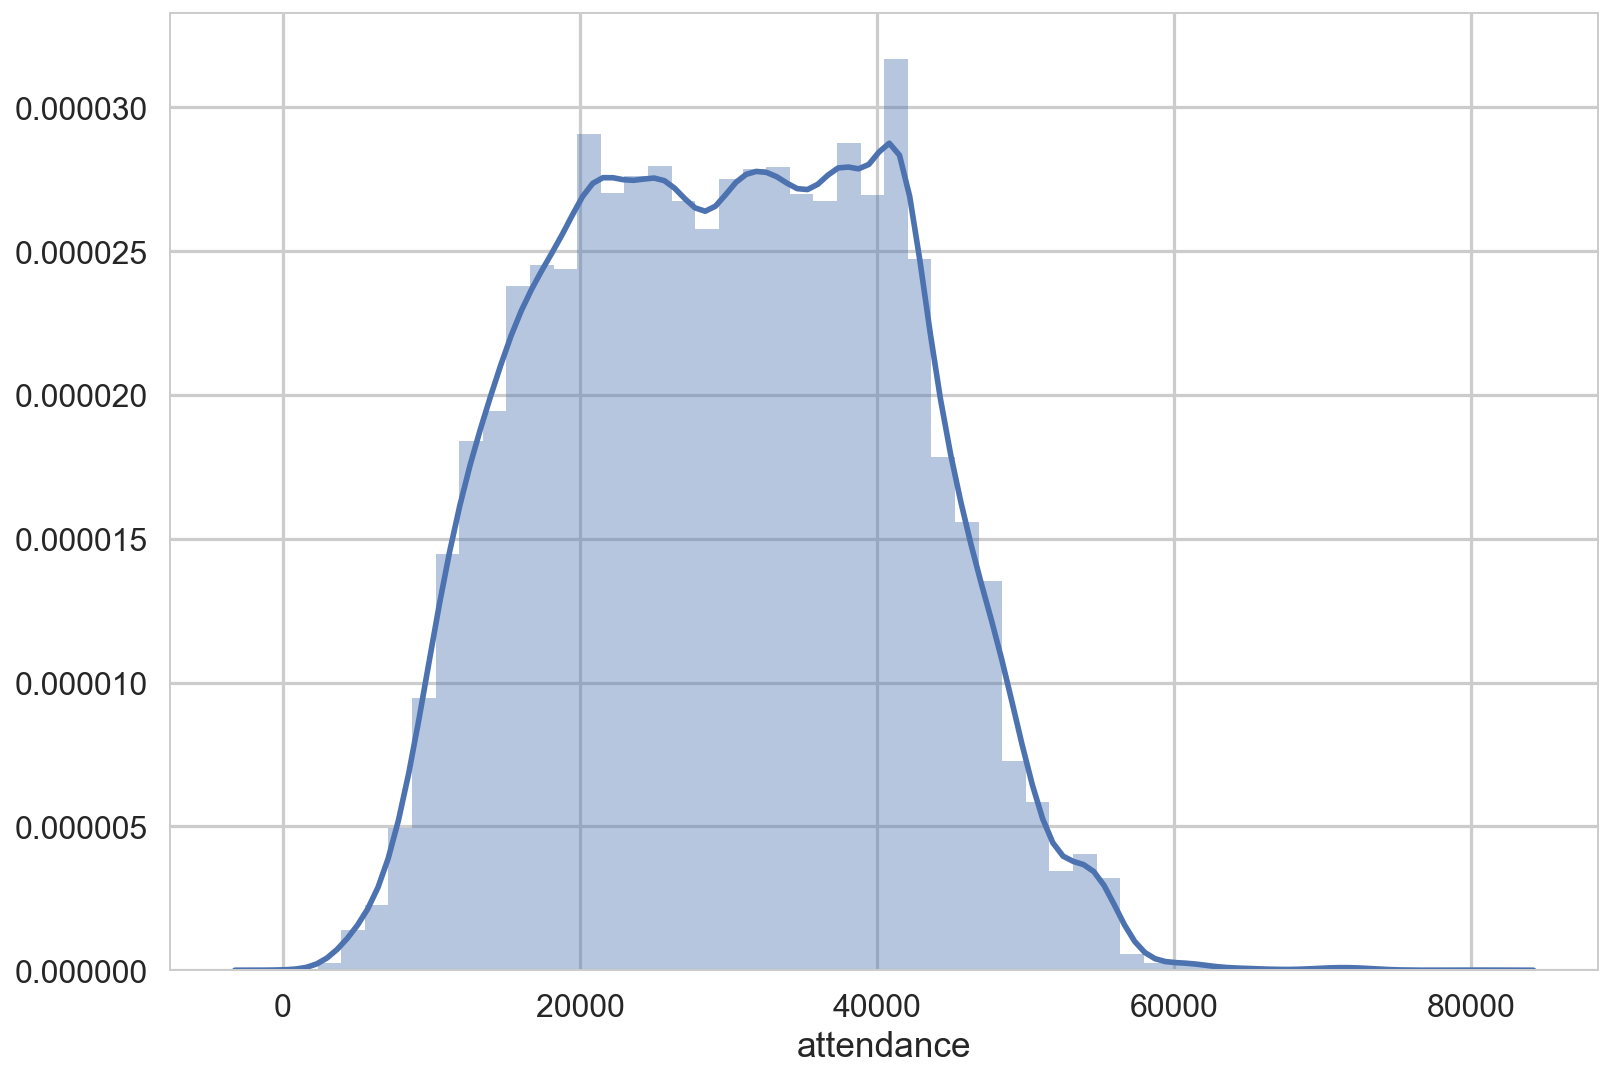

In [22]:
sns.distplot(all_teams.attendance)

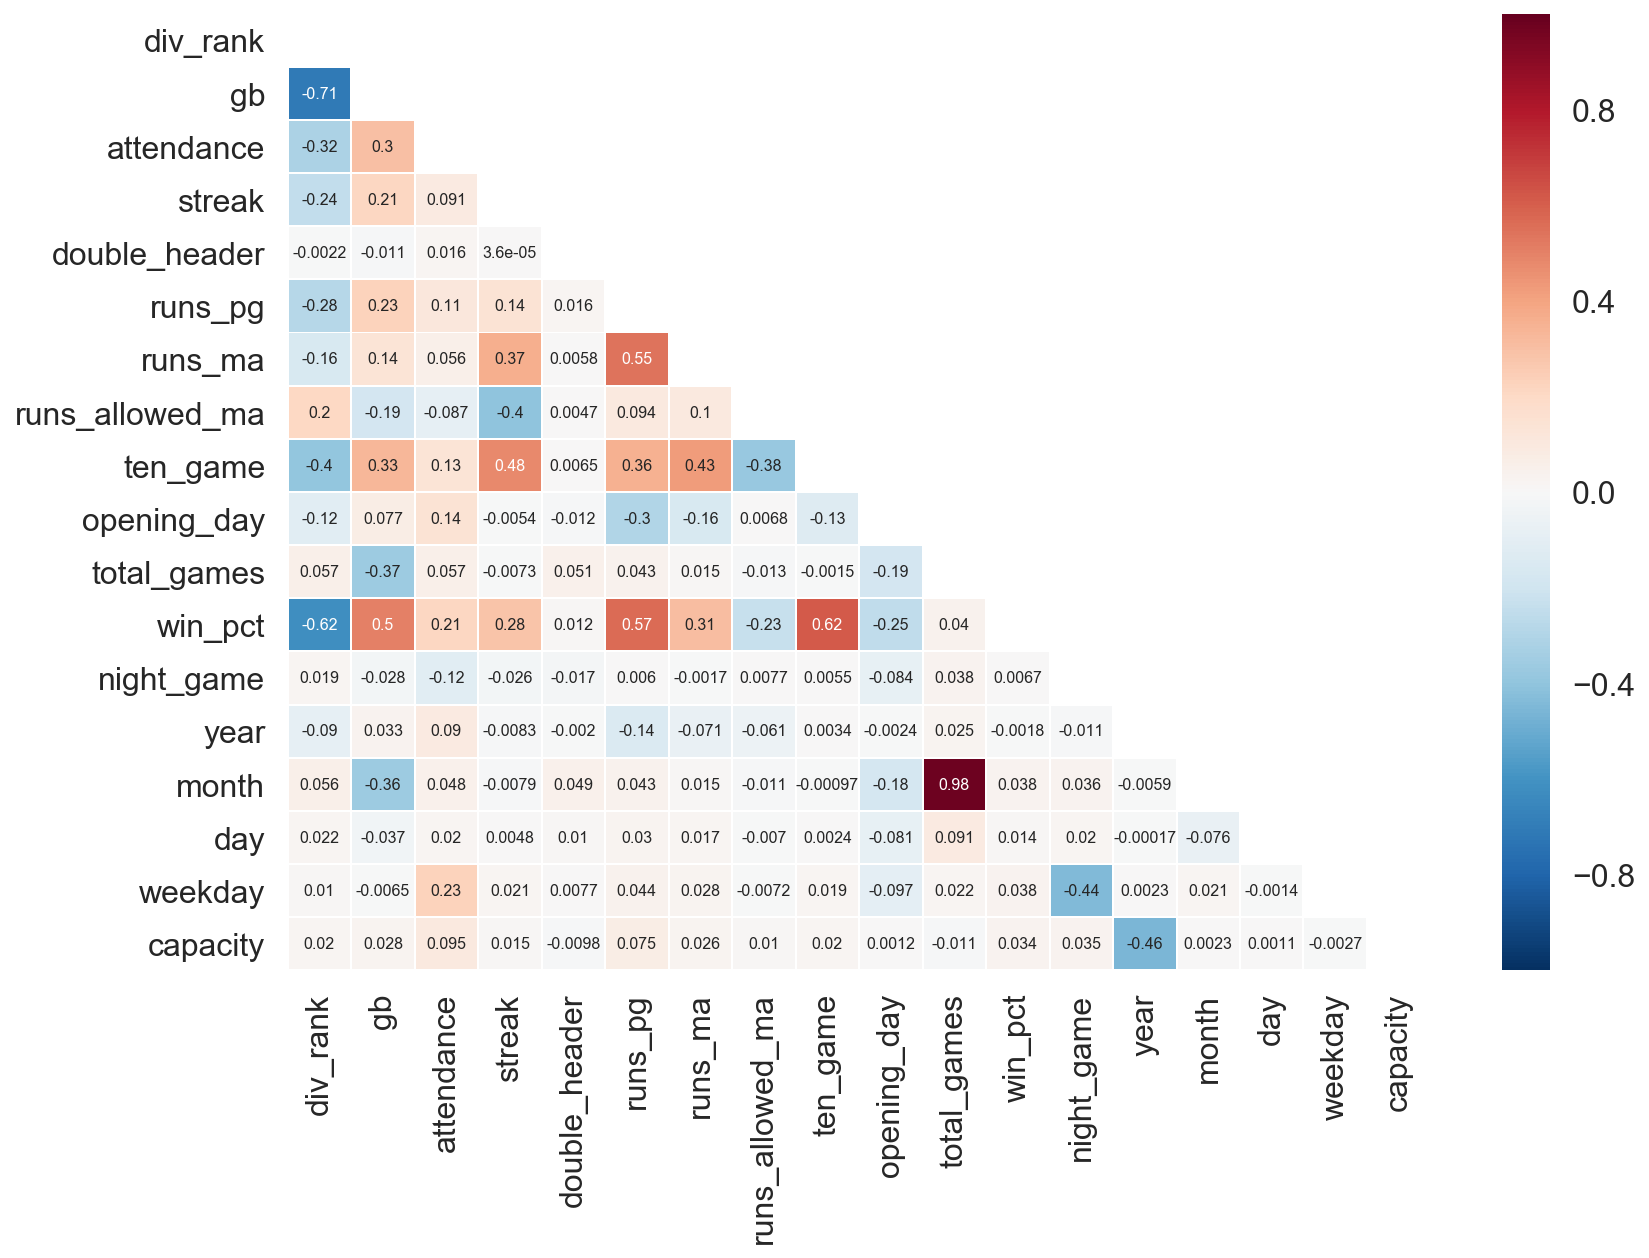

In [23]:
corr = all_teams.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 8})

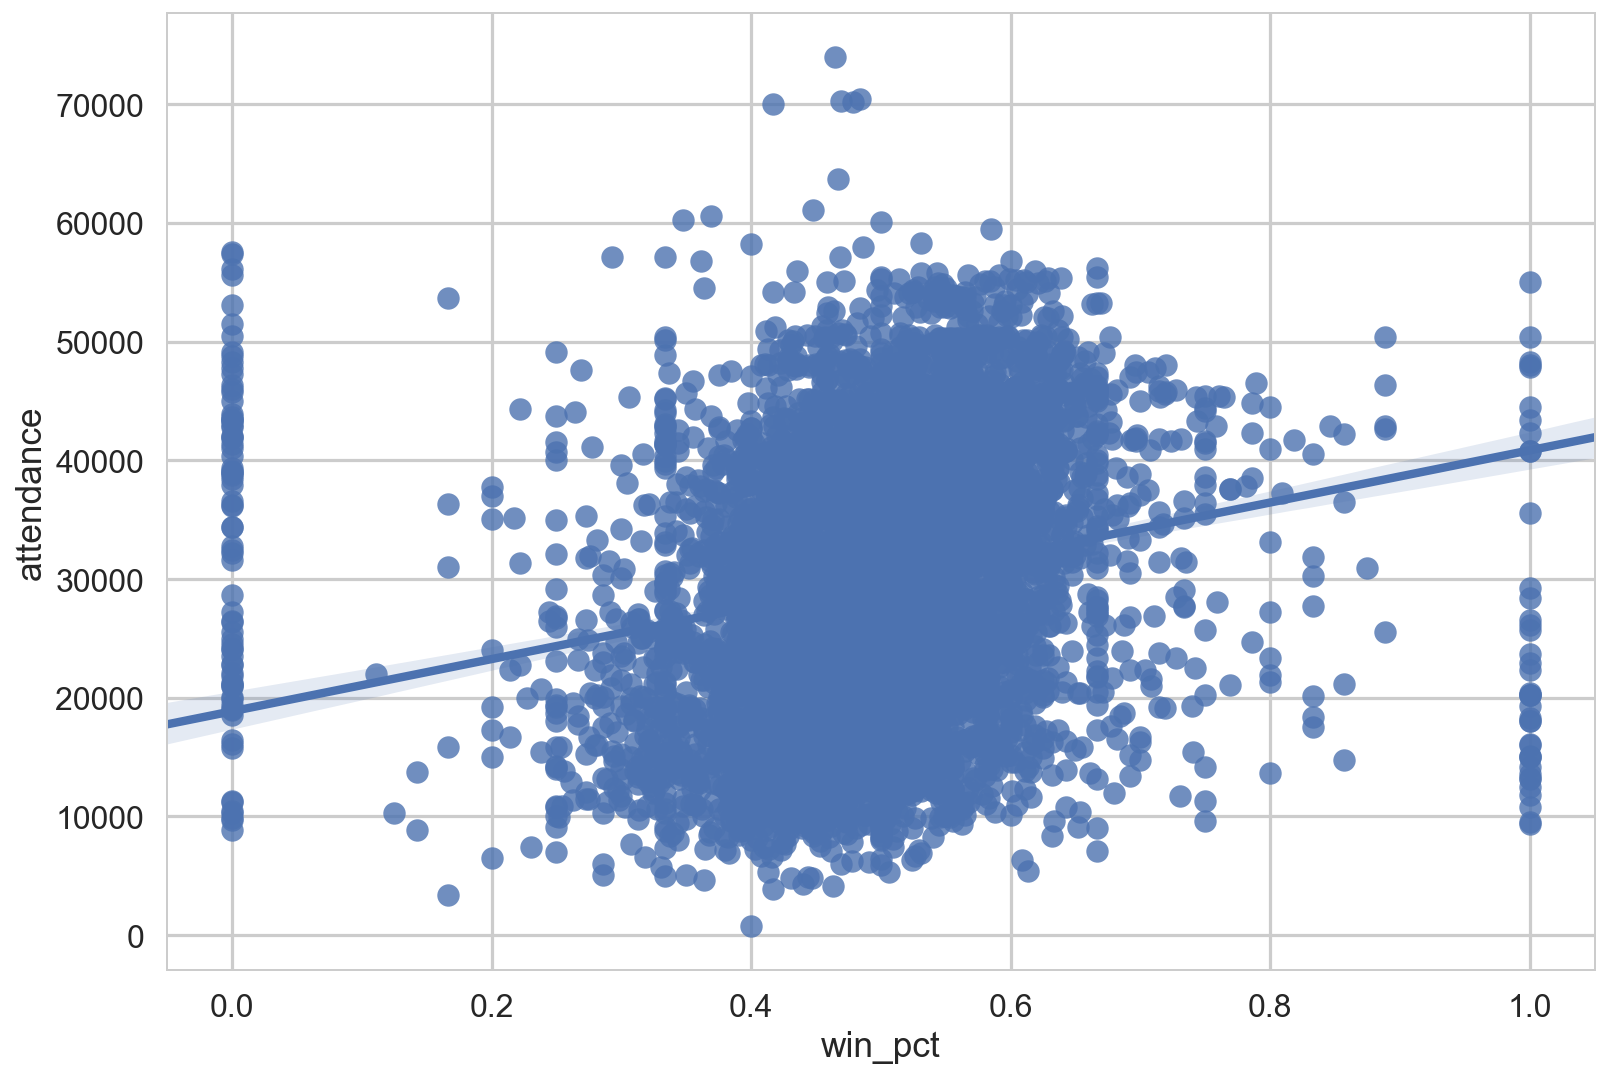

In [24]:
sns.regplot(x='win_pct', y='attendance', data=all_teams.sample(frac=.1))

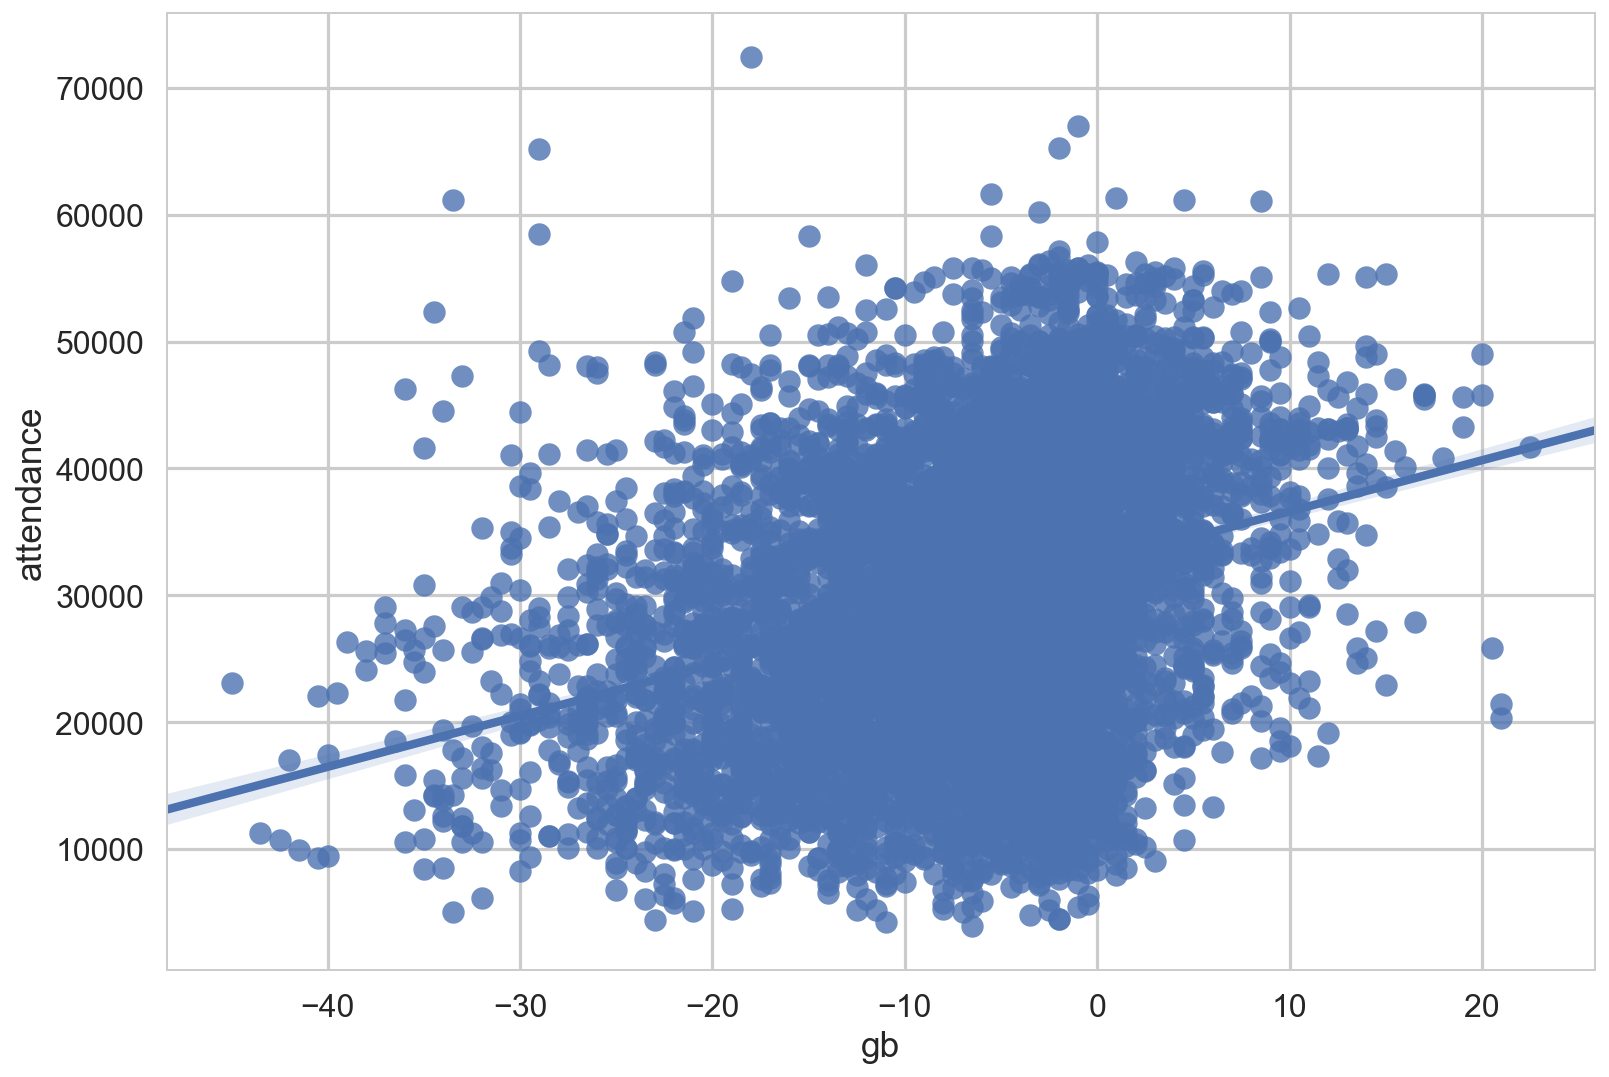

In [25]:
sns.regplot(x='gb', y='attendance', data=all_teams.sample(frac=.1))

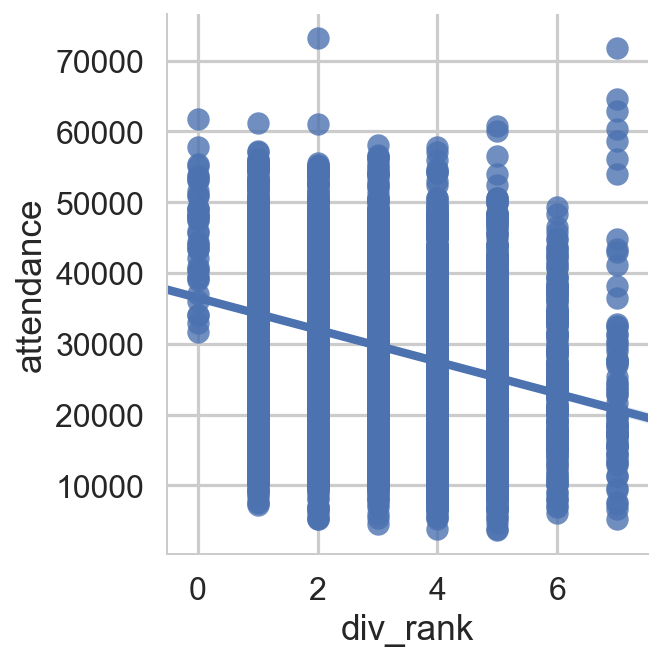

In [26]:
sns.lmplot(x='div_rank', y='attendance', data=all_teams.sample(frac=.1))

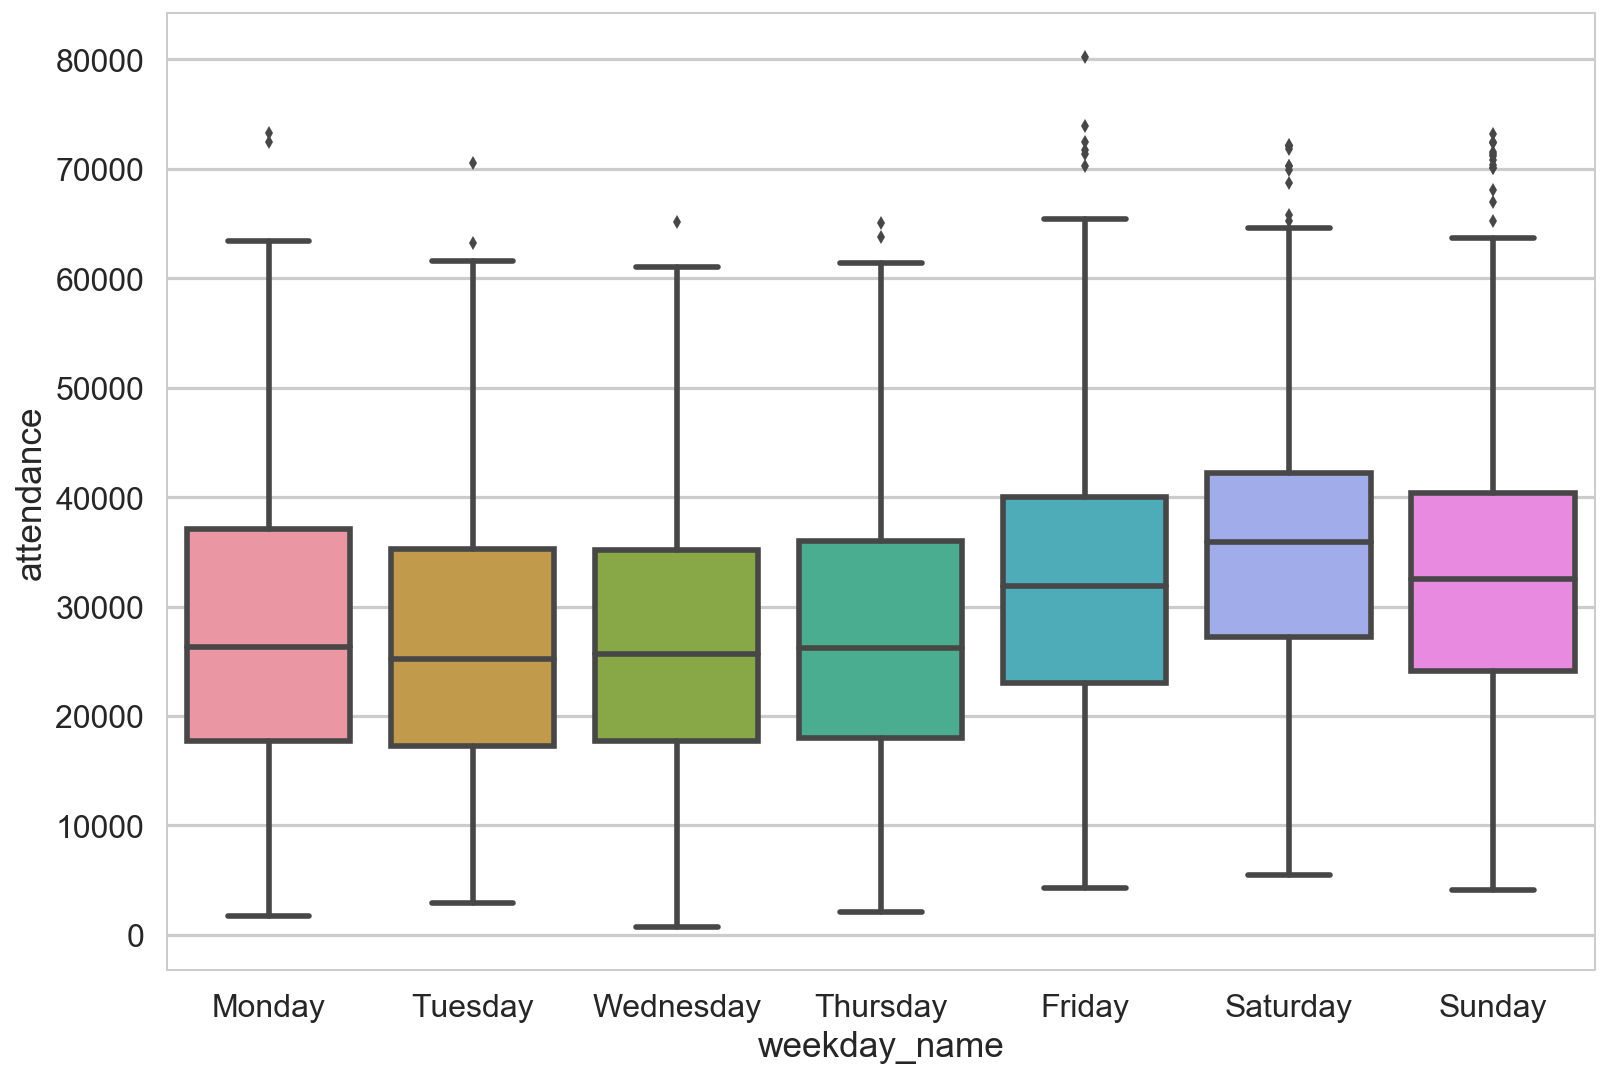

In [27]:
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.boxplot(x='weekday_name', y='attendance', data=all_teams, order=order)

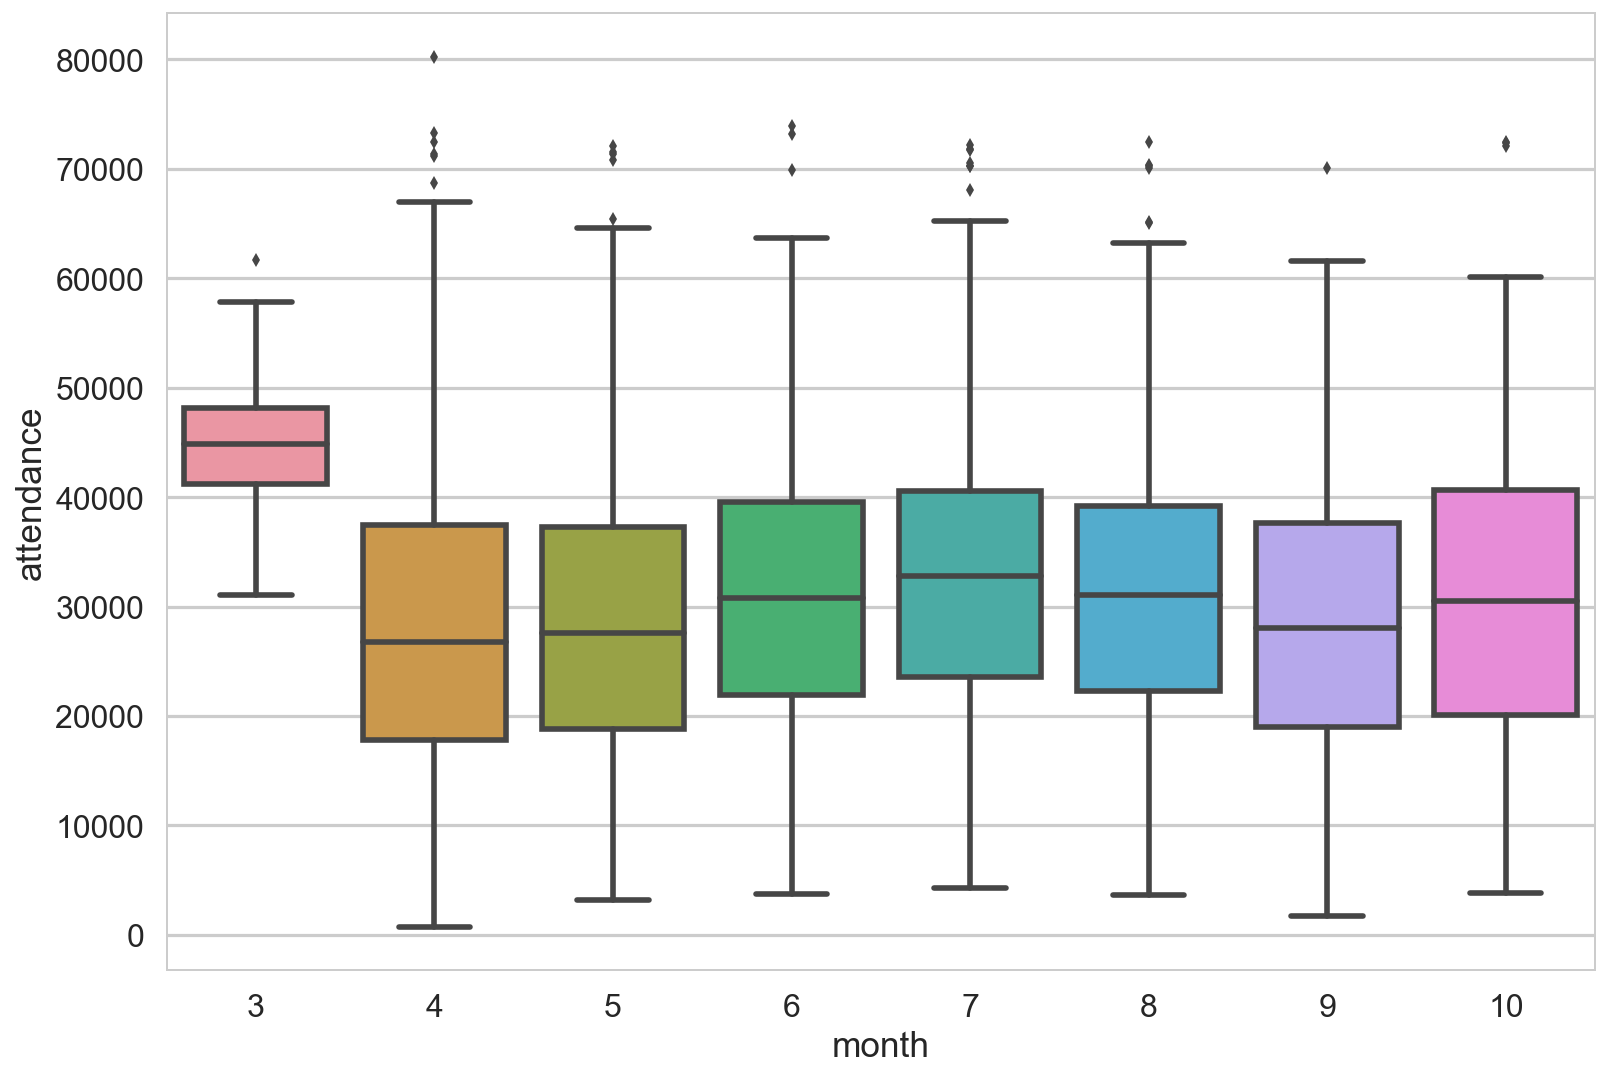

In [28]:
sns.boxplot(x='month', y='attendance', data=all_teams)

In [29]:
all_teams.describe()

,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,capacity
count,62415.000000,62415.000000,62415,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000,62415.000000
mean,3.021005,-6.664416,0 days 02:56:22.434991,29727.469454,0.136682,0.016326,4.586164,4.587114,4.582735,0.456931,0.012625,79.444172,0.497467,0.679436,2003.449139,6.571689,15.853513,3.191156,46889.292125
std,1.556652,8.839055,0 days 00:27:21.655628,11391.712381,2.552386,0.126728,0.857838,1.572443,1.511675,0.179771,0.111651,46.448793,0.113334,0.466697,7.668986,1.708079,8.858365,1.977775,7520.666815
min,0.000000,-52.000000,0 days 01:14:00,746.000000,-15.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1990.000000,3.000000,1.000000,0.000000,31042.000000
25%,2.000000,-11.500000,0 days 02:38:00,20546.500000,-1.000000,0.000000,4.147059,3.600000,3.400000,0.300000,0.000000,39.000000,0.440678,0.000000,1997.000000,5.000000,8.000000,1.000000,41313.000000
50%,3.000000,-5.000000,0 days 02:53:00,29855.000000,1.000000,0.000000,4.561905,4.400000,4.400000,0.500000,0.000000,79.000000,0.500000,1.000000,2004.000000,7.000000,16.000000,3.000000,45757.000000
75%,4.000000,-1.000000,0 days 03:10:00,38804.500000,2.000000,0.000000,5.020906,5.600000,5.600000,0.600000,0.000000,119.000000,0.558140,1.000000,2010.000000,8.000000,24.000000,5.000000,50516.000000
max,7.000000,29.000000,0 days 07:06:00,80227.000000,19.000000,1.000000,16.000000,16.000000,12.800000,1.000000,1.000000,162.000000,1.000000,1.000000,2016.000000,10.000000,31.000000,6.000000,76273.000000


In [30]:
all_teams[all_teams.attendance == min(all_teams.attendance)]
# wednesday day game with Clemens of the mound

,date,team,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name,stadium,capacity
11791,1997-04-09,CHW,TOR,4,-1.5,03:05:00,746,1,0,6.2,6.2,7.4,0.4,0,5,0.4,0,1997,4,9,2,Wednesday,US Cellular Field,44321


In [31]:
all_teams[all_teams.attendance == max(all_teams.attendance)]

,date,team,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name,stadium,capacity
17649,1993-04-09,COL,MON,6,-1.5,02:42:00,80227,-2,0,0.5,0.5,7.4,0.0,1,2,0.0,0,1993,4,9,4,Friday,Mile High Stadium,76273


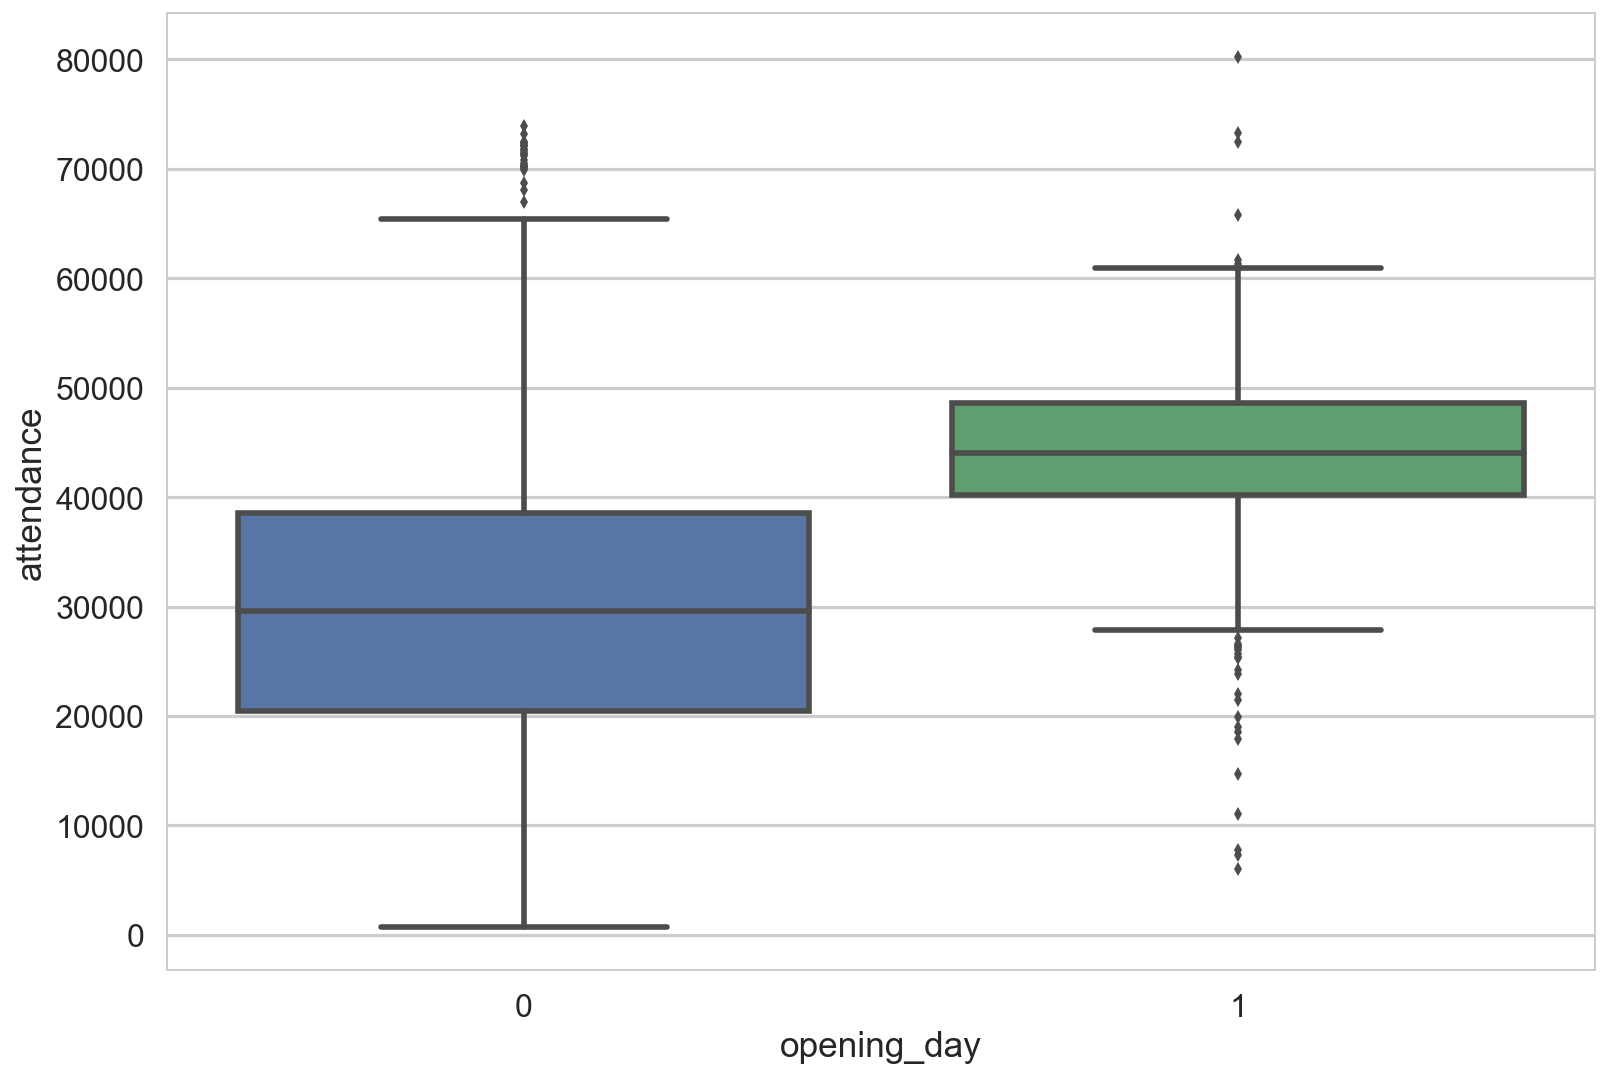

In [32]:
sns.boxplot(x='opening_day', y='attendance', data=all_teams)

### Plotting Yearly Data

In [33]:
yearly.sort_values('attendance').head(10)

,team,year,stadium,capacity,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR,num_home_games,avg_att_pg
456,MON,2001,Olympic Stadium,45757,Montreal Expos,NL East,162,0.420,20.0,0,642745,27.6,27.4,J.Vazquez,6.3,81.0,7935.123457
459,MON,2004,Olympic Stadium,45757,Montreal Expos,NL East,162,0.414,29.0,0,749550,27.5,26.5,L.Hernandez,5.8,80.0,9369.375000
454,MON,1999,Olympic Stadium,45757,Montreal Expos,NL East,162,0.420,35.0,0,773277,25.9,25.5,V.Guerrero,4.4,81.0,9546.629630
457,MON,2002,Olympic Stadium,45757,Montreal Expos,NL East,162,0.512,19.0,0,812045,28.2,27.7,V.Guerrero,7.0,81.0,10025.246914
283,FLA,2002,Sun Life Stadium,36331,Florida Marlins,NL East,162,0.488,23.0,0,813118,28.4,26.1,A.Burnett,4.0,81.0,10038.493827
573,PIT,1995,Three Rivers Stadium,47952,Pittsburgh Pirates,NL Central,144,0.403,27.0,0,905517,28.3,26.4,D.Neagle,4.5,70.0,12935.957143
453,MON,1998,Olympic Stadium,45757,Montreal Expos,NL East,162,0.401,41.0,0,914909,25.9,25.7,V.Guerrero,7.4,81.0,11295.172840
455,MON,2000,Olympic Stadium,45757,Montreal Expos,NL East,162,0.414,28.0,0,926272,26.2,26.1,V.Guerrero,5.9,81.0,11435.456790
446,MON,1991,Olympic Stadium,45757,Montreal Expos,NL East,161,0.441,26.5,0,934742,27.7,28.4,D.Martinez,5.8,67.0,13951.373134
599,SDP,1994,Qualcomm Stadium,46510,San Diego Padres,NL West,117,0.402,12.5,0,953857,27.2,26.8,T.Gwynn,4.2,57.0,16734.333333


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

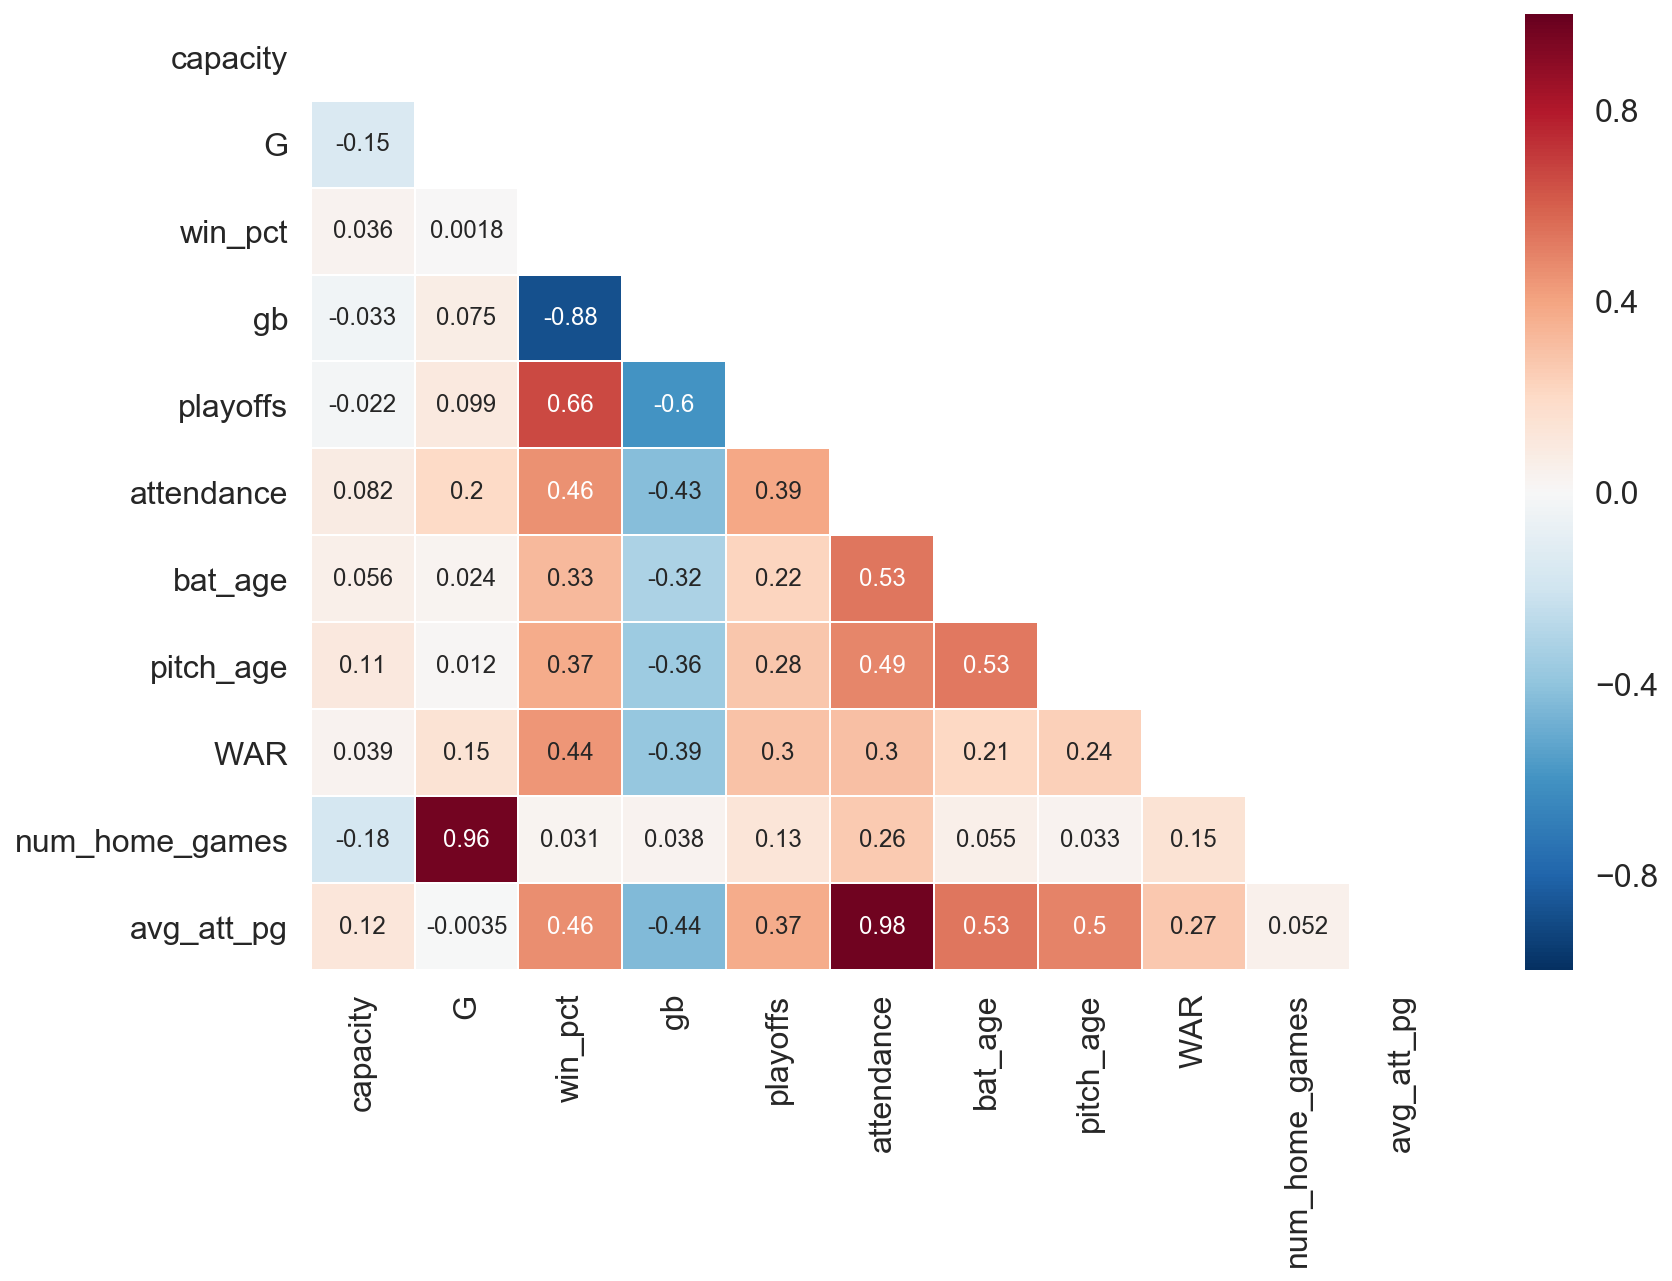

In [34]:
corr = yearly.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 12})
plt.xticks(rotation=90)

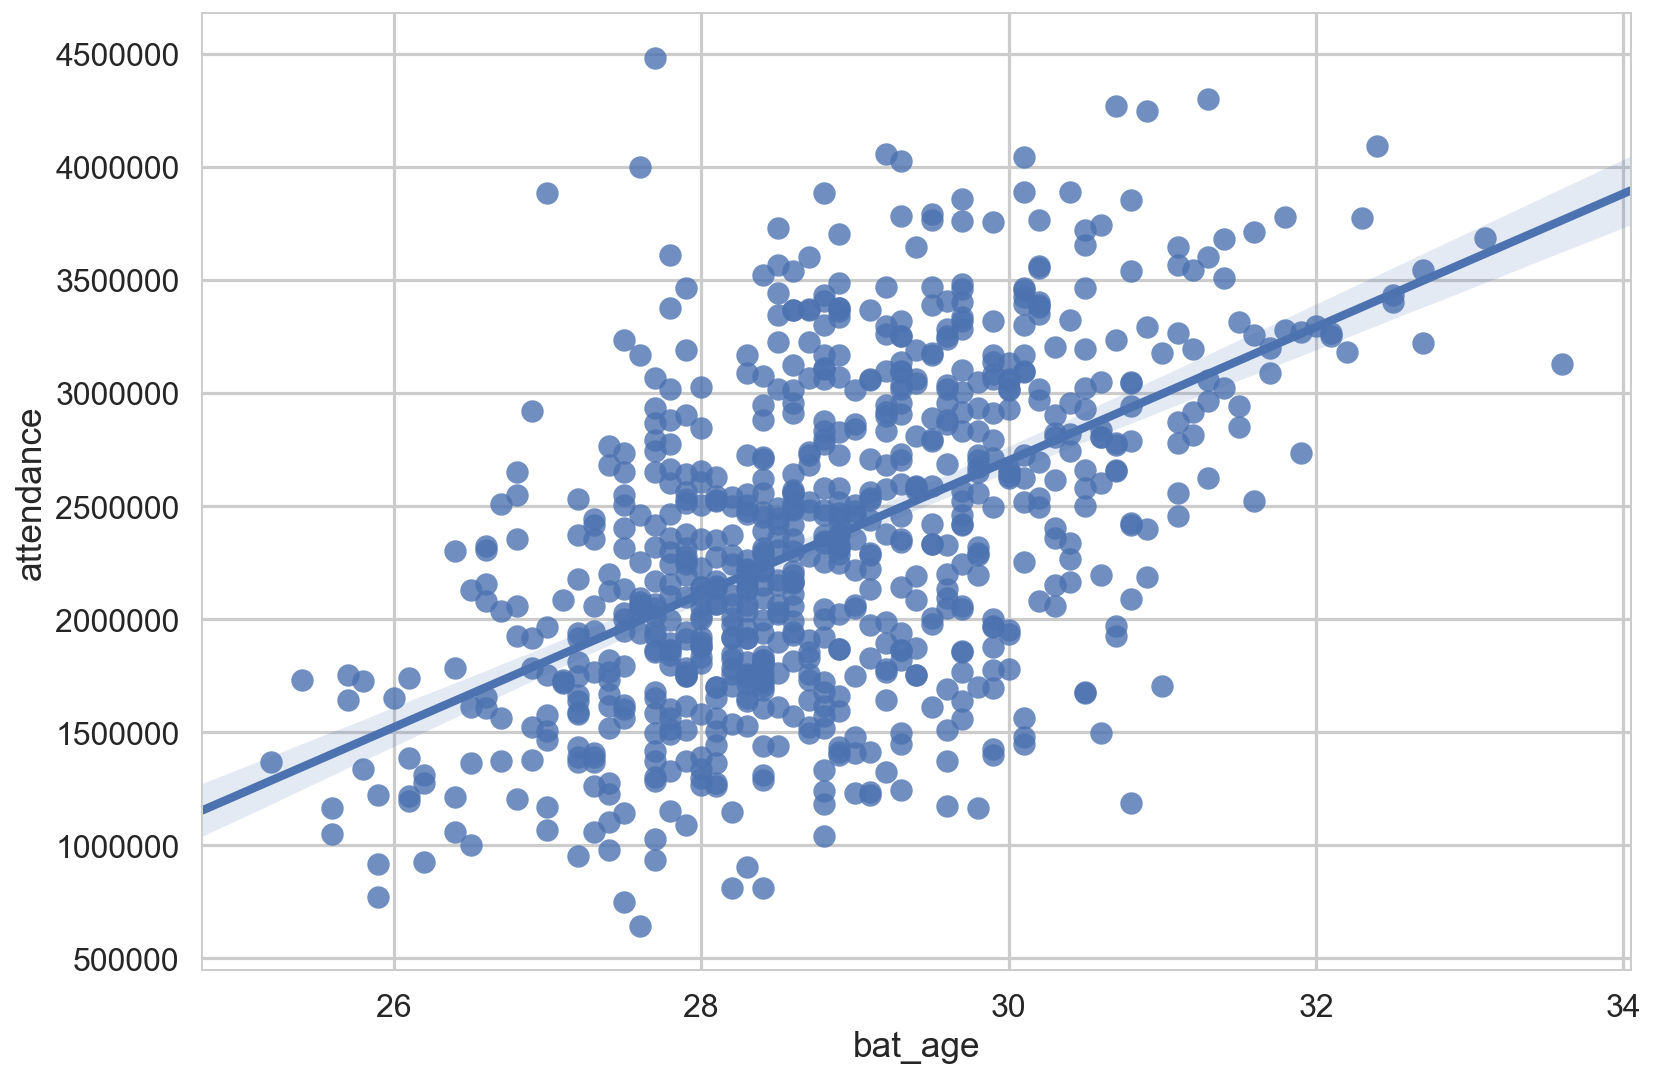

In [35]:
sns.regplot(x='bat_age', y='attendance', data=yearly)

In [36]:
yearly[(yearly.bat_age < 26) | (yearly.bat_age > 32)].sort_values('bat_age')

,team,year,stadium,capacity,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR,num_home_games,avg_att_pg
280,FLA,1999,Sun Life Stadium,35521,Florida Marlins,NL East,162,0.395,39.0,0,1369421,25.2,26.0,A.Fernandez,3.4,78.0,17556.679487
279,FLA,1998,Sun Life Stadium,42531,Florida Marlins,NL East,162,0.333,52.0,0,1730384,25.4,24.5,M.Kotsay,3.9,79.0,21903.594937
287,FLA,2006,Sun Life Stadium,36331,Florida Marlins,NL East,162,0.481,19.0,0,1164134,25.6,25.9,M.Cabrera,5.8,81.0,14372.024691
197,CLE,1991,Cleveland Stadium,74483,Cleveland Indians,AL East,162,0.352,34.0,0,1051863,25.6,26.8,G.Swindell,3.8,79.0,13314.721519
448,MON,1993,Olympic Stadium,45757,Montreal Expos,NL East,163,0.580,3.0,0,1641437,25.7,27.9,M.Grissom,5.2,81.0,20264.654321
317,HOU,2014,Minute Maid Park,42060,Houston Astros,AL West,162,0.432,28.0,0,1751829,25.7,27.9,J.Altuve,6.1,81.0,21627.518519
151,CHW,1999,US Cellular Field,44321,Chicago White Sox,AL Central,162,0.466,21.5,0,1338851,25.8,26.4,M.Ordonez,5.8,76.0,17616.460526
341,KCR,2011,Kauffman Stadium,37903,Kansas City Royals,AL Central,162,0.438,24.0,0,1724450,25.8,26.4,A.Gordon,7.2,81.0,21289.506173
453,MON,1998,Olympic Stadium,45757,Montreal Expos,NL East,162,0.401,41.0,0,914909,25.9,25.7,V.Guerrero,7.4,81.0,11295.172840
454,MON,1999,Olympic Stadium,45757,Montreal Expos,NL East,162,0.420,35.0,0,773277,25.9,25.5,V.Guerrero,4.4,81.0,9546.629630


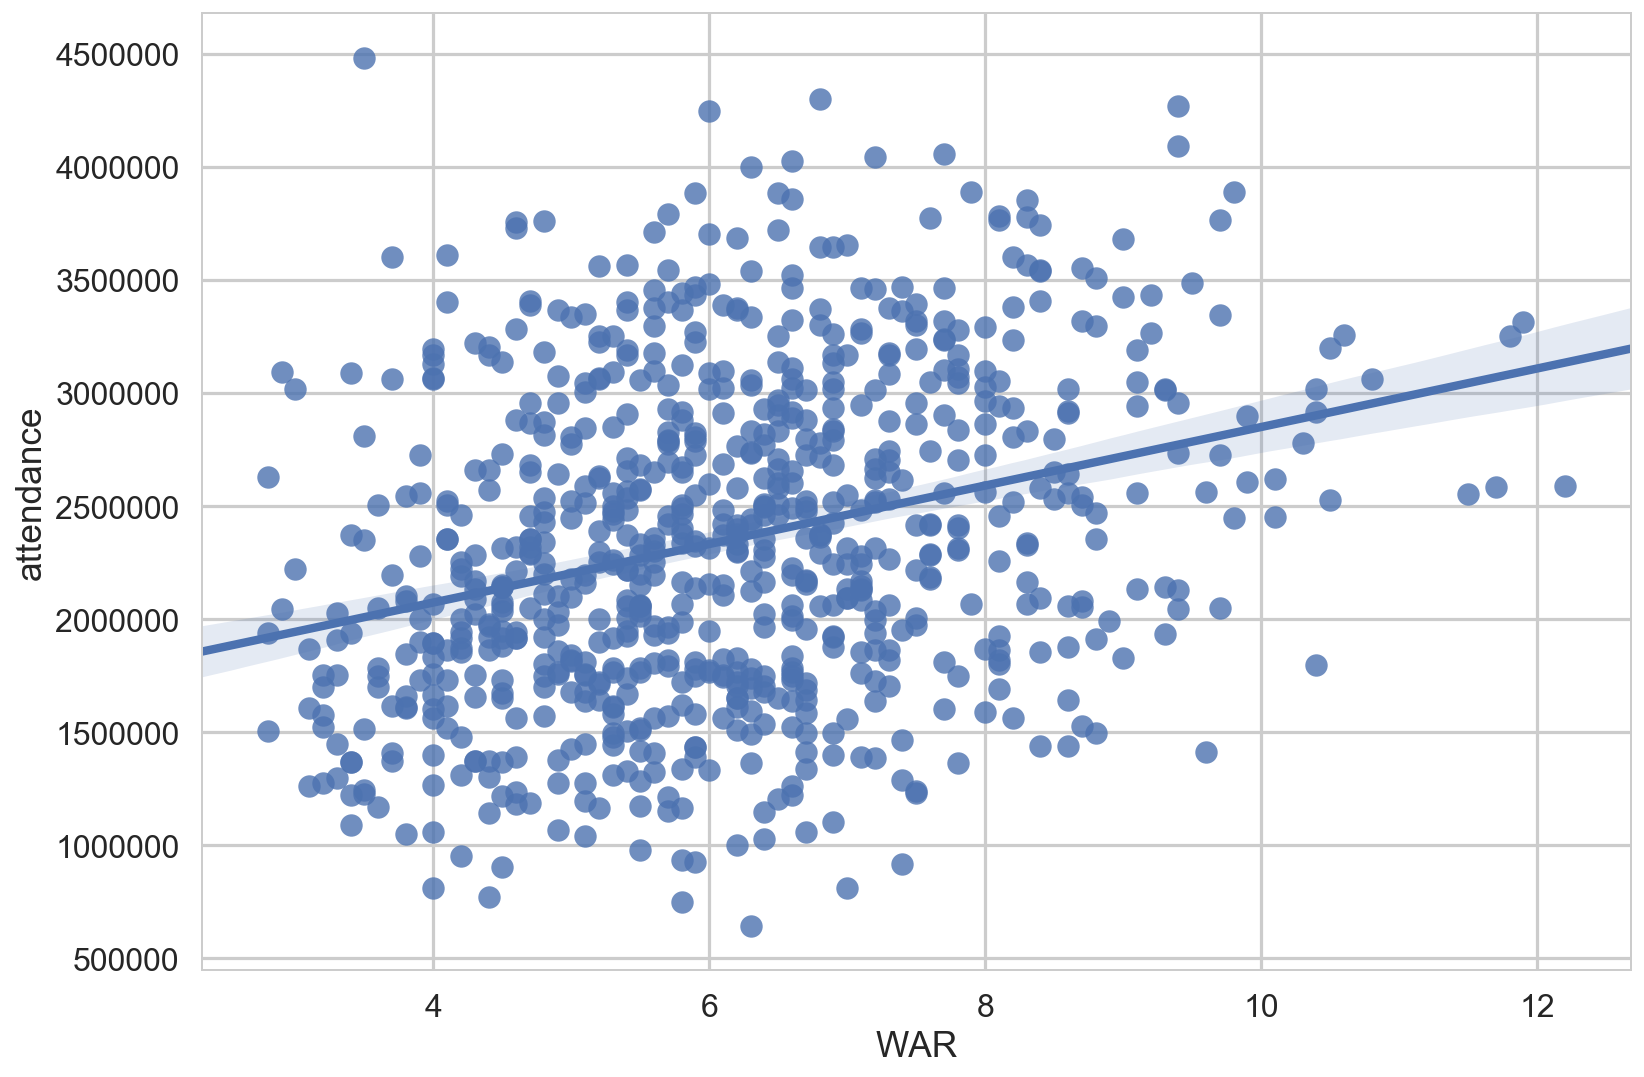

In [37]:
sns.regplot(x='WAR', y='attendance', data=yearly)

In [38]:
yearly[yearly.WAR > 10].sort_values('WAR')

,team,year,stadium,capacity,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR,num_home_games,avg_att_pg
172,CIN,1993,Riverfront Stadium,52952,Cincinnati Reds,NL West,162,0.451,31.0,0,2453232,28.4,27.9,J.Rijo,10.1,79.0,31053.569620
786,WSN,2015,Nationals Park,41418,Washington Nationals,NL East,162,0.512,7.0,0,2619843,28.4,28.6,B.Harper,10.1,81.0,32343.740741
126,CHC,2001,Wrigley Field,39059,Chicago Cubs,NL Central,162,0.543,5.0,0,2779465,30.7,29.8,S.Sosa,10.3,79.0,35183.101266
339,KCR,2009,Kauffman Stadium,37903,Kansas City Royals,AL Central,162,0.401,21.5,0,1797891,27.8,28.7,Z.Greinke,10.4,80.0,22473.637500
358,LAA,2016,Angel Stadium,45493,Los Angeles Angels of Anaheim,AL West,162,0.457,21.0,0,3016142,28.5,28.4,M.Trout,10.4,81.0,37236.320988
632,SEA,2000,Safeco Field,47116,Seattle Mariners,AL West,162,0.562,0.5,1,2914624,31.2,29.3,A.Rodriguez,10.4,81.0,35983.012346
12,ARI,2002,Chase Field,49033,Arizona Diamondbacks,NL West,162,0.605,0.0,1,3198977,31.7,31.7,R.Johnson,10.5,81.0,39493.543210
81,BOS,1990,Fenway Park,34182,Boston Red Sox,AL East,162,0.543,0.0,1,2528986,29.1,30.6,R.Clemens,10.5,80.0,31612.325000
663,SFG,2004,AT&T Park,41503,San Francisco Giants,NL West,162,0.562,2.0,0,3256854,31.6,30.1,B.Bonds,10.6,81.0,40208.074074
354,LAA,2012,Angel Stadium,45957,Los Angeles Angels of Anaheim,AL West,162,0.549,5.0,0,3061770,28.8,30.1,M.Trout,10.8,81.0,37799.629630


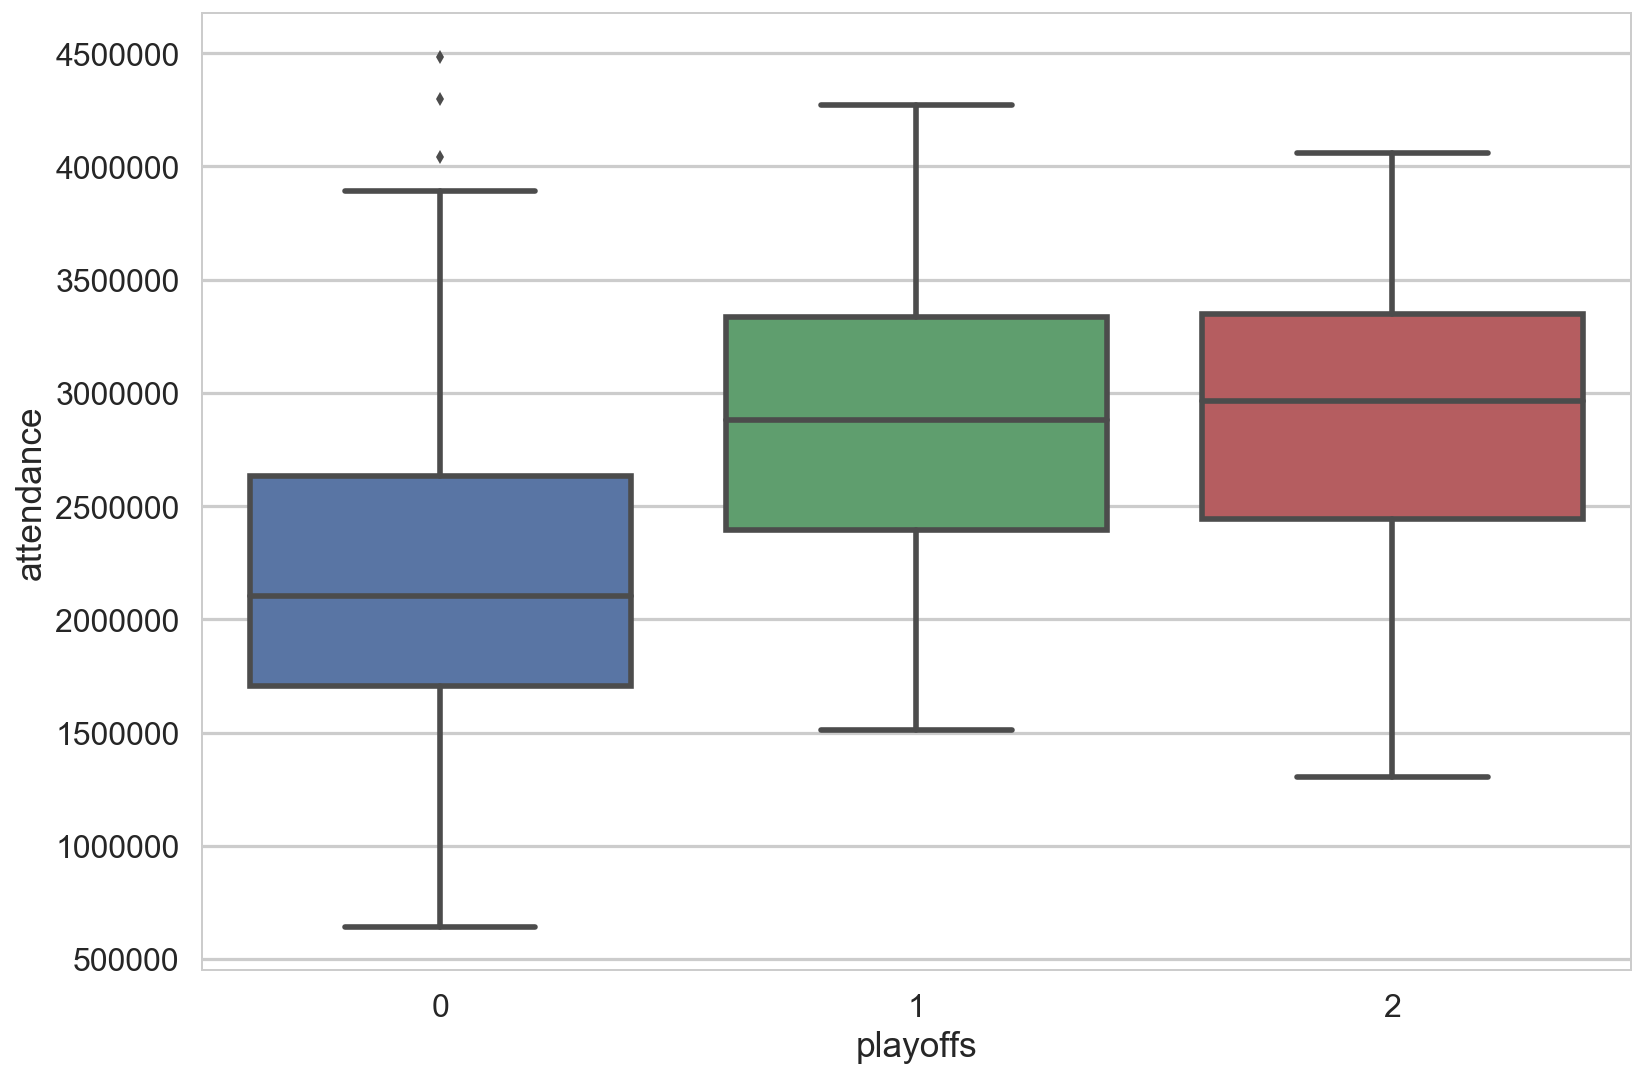

In [39]:
sns.boxplot(x='playoffs', y='attendance', data=yearly)

#### Adding division, bat_age, pitch_age, WAR into all_teams df

In [40]:
all_teams = all_teams.merge(yearly[['team', 'year', 'bat_age', 'pitch_age', 'division']],
                            on=['team', 'year'])
all_teams = all_teams.merge(yearly[['team', 'year', 'division']], left_on=['opponent', 'year'],
                            right_on=['team', 'year'])

In [41]:
%time all_teams['division_game'] = [1 if all_teams.loc[i].division_x == all_teams.loc[i].division_y else 0 for i in range(0,len(all_teams))]
all_teams.drop(['division_x', 'team_y', 'division_y'], axis=1, inplace=True)

CPU times: user 29.5 s, sys: 186 ms, total: 29.7 s
Wall time: 29.7 s


In [42]:
all_teams.sample(frac=.1).head(10)

,date,team_x,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name,stadium,capacity,bat_age,pitch_age,division_game
17344,2004-04-18,CHC,CIN,3,-1.5,03:13:00,39624,-1,0,5.272727,6.6,6.8,0.4,0,11,0.545455,0,2004,4,18,6,Sunday,Wrigley Field,39345,30.1,29.1,1
50935,1995-06-27,NYY,DET,3,-6.5,02:53:00,19765,5,0,5.092593,6.6,2.0,0.7,0,54,0.462963,1,1995,6,27,1,Tuesday,Yankee Stadium I,57545,31.0,28.1,1
43425,2010-08-24,LAA,TBR,3,-9.0,03:11:00,43577,-2,0,4.428571,4.2,4.0,0.3,0,126,0.492063,1,2010,8,24,1,Tuesday,Angel Stadium,45389,29.6,28.3,0
60231,2015-08-22,BOS,KCR,5,-11.5,03:29:00,37135,4,0,4.549180,5.6,3.2,0.6,0,122,0.459016,1,2015,8,22,5,Saturday,Fenway Park,37673,28.4,28.6,0
35725,1991-06-30,CHC,STL,4,-12.5,02:30:00,32736,1,0,4.135135,5.2,6.0,0.2,0,74,0.445946,0,1991,6,30,6,Sunday,Wrigley Field,38711,28.9,27.5,1
49312,1993-07-05,CAL,BOS,3,-3.0,03:31:00,20442,1,0,4.544304,5.0,6.4,0.1,0,79,0.481013,1,1993,7,5,0,Monday,Angel Stadium,64593,27.3,28.8,0
19538,2006-06-05,COL,PIT,5,-7.0,02:43:00,20152,-5,0,4.053571,1.4,5.2,0.2,0,56,0.482143,1,2006,6,5,0,Monday,Coors Field,50445,27.8,28.8,0
51624,1996-07-19,CHW,KCR,2,-3.0,03:34:00,19604,-2,0,5.610526,4.6,6.2,0.5,0,95,0.568421,1,1996,7,19,4,Friday,US Cellular Field,44321,30.5,27.8,1
44398,2013-08-07,KCR,MIN,3,-8.5,03:09:00,20198,-1,0,4.018182,5.0,3.2,0.8,0,110,0.518182,1,2013,8,7,2,Wednesday,Kauffman Stadium,37903,27.0,28.9,1
10314,2004-06-17,FLA,CHW,1,1.5,03:11:00,17857,1,0,4.492308,4.8,4.6,0.5,0,65,0.553846,1,2004,6,17,3,Thursday,Sun Life Stadium,36331,28.8,27.8,0


In [43]:
all_teams.dtypes

date                datetime64[ns]
team_x                      object
opponent                    object
div_rank                     int64
gb                         float64
time               timedelta64[ns]
attendance                   int64
streak                       int64
double_header                int64
runs_pg                    float64
runs_ma                    float64
runs_allowed_ma            float64
ten_game                   float64
opening_day                  int64
total_games                  int64
win_pct                    float64
night_game                   int64
year                        object
month                        int64
day                          int64
weekday                      int64
weekday_name                object
stadium                     object
capacity                     int64
bat_age                    float64
pitch_age                  float64
division_game                int64
dtype: object

In [44]:
all_teams.night_game.value_counts()

1    42407
0    20008
Name: night_game, dtype: int64

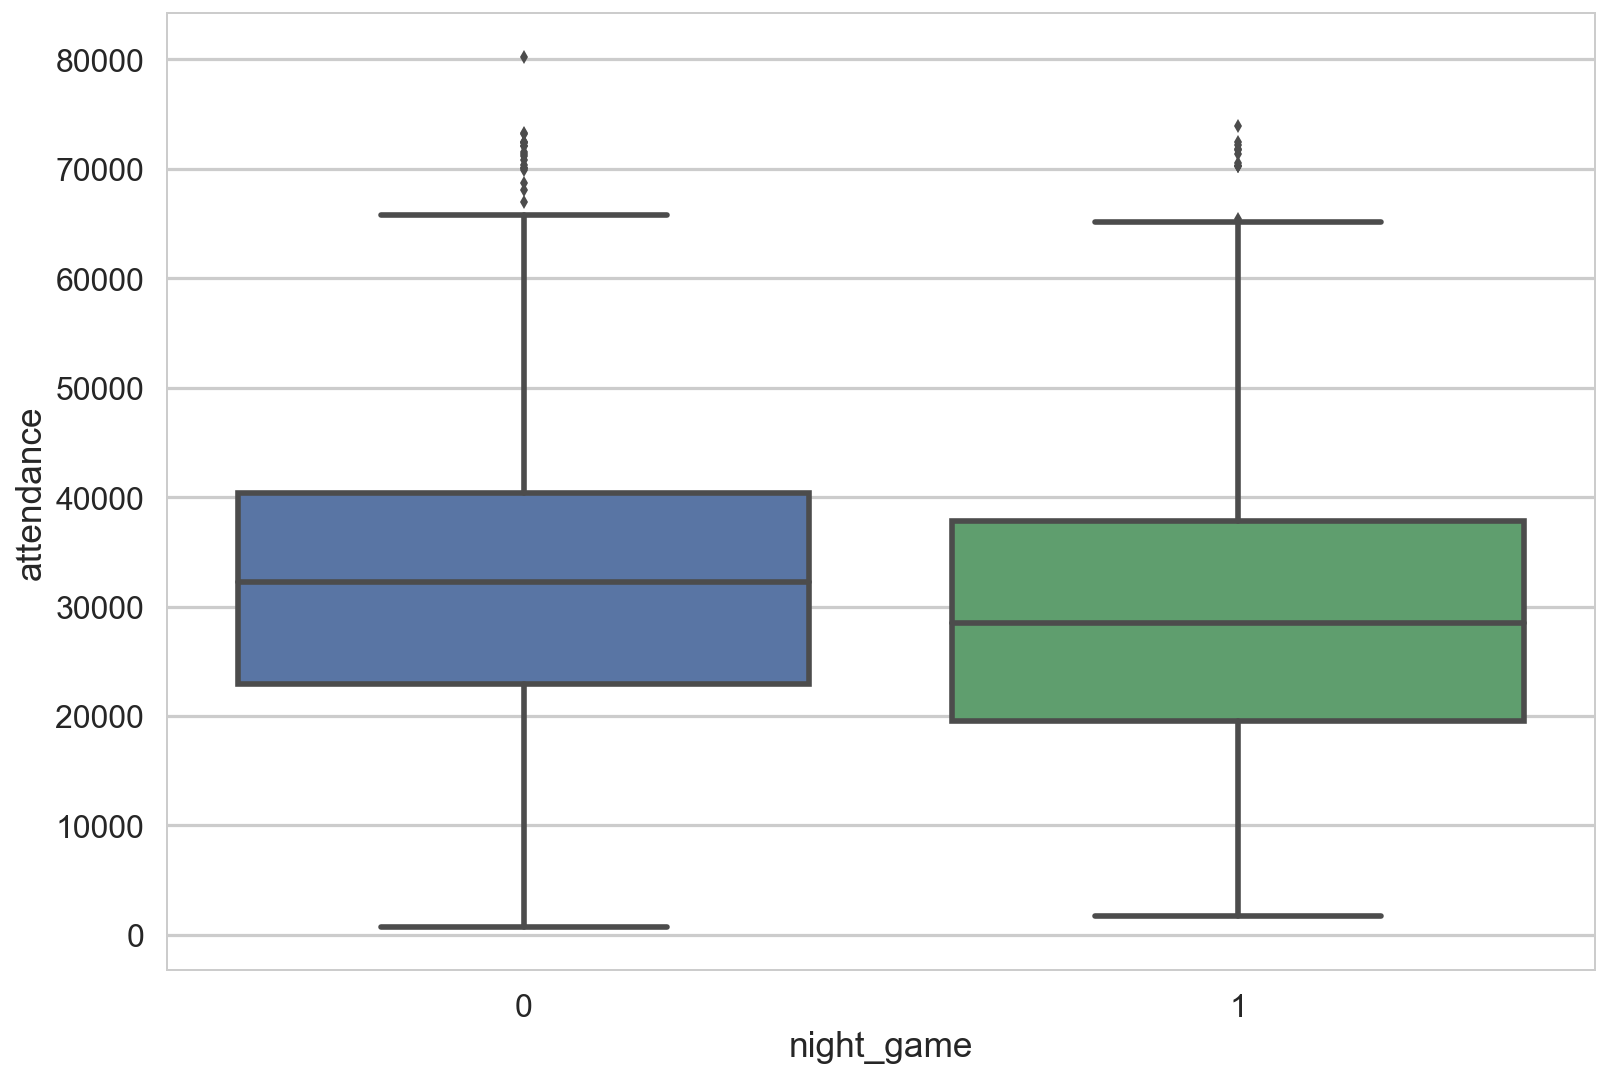

In [45]:
sns.boxplot(x='night_game', y='attendance', data=all_teams)

In [46]:
all_teams.division_game.value_counts()

0    35836
1    26579
Name: division_game, dtype: int64

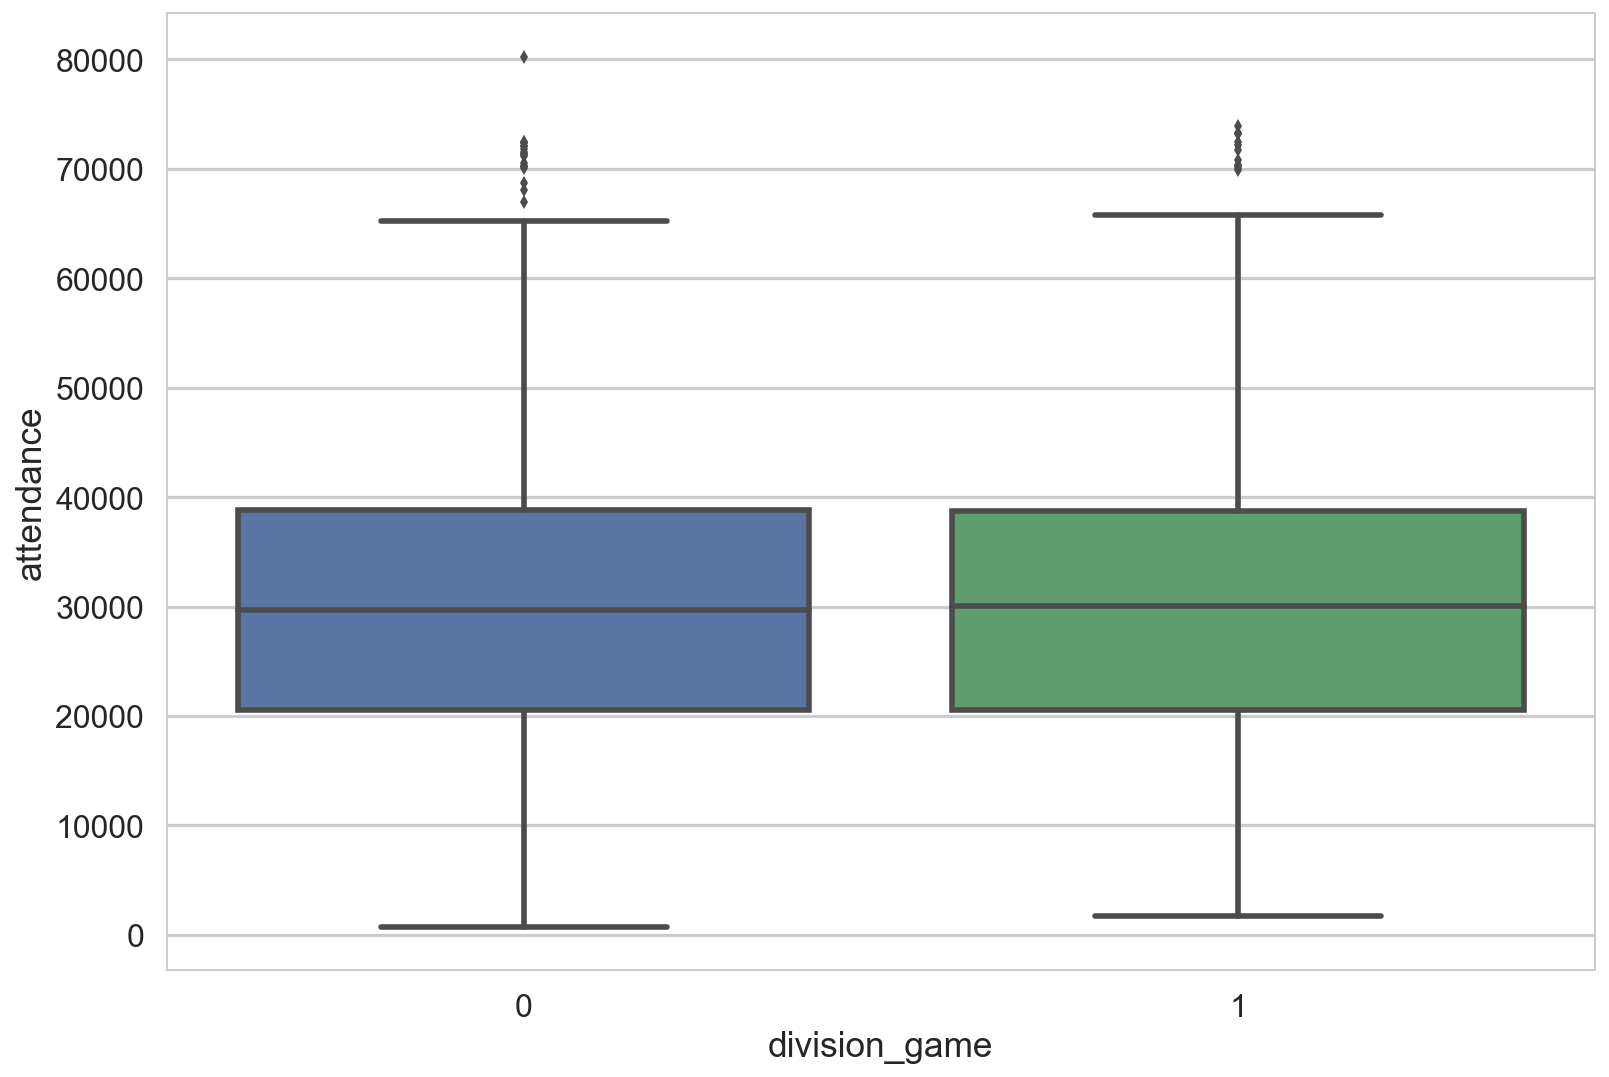

In [47]:
sns.boxplot(x='division_game', y='attendance', data=all_teams)

### Create CSV files

In [48]:
all_teams.to_csv('../data/all-teams-1990-2016.csv', index=False, encoding = 'utf-8')

In [49]:
for i in all_teams.team_x.unique():
    df = all_teams[all_teams.team_x == i]
    df.to_csv('../data/' + i + '-game-data.csv', index=False, encoding='utf-8')

In [50]:
yearly.to_csv('../data/yearly-team-data.csv', index=False, encoding='utf-8')